# Part 1. Gender Classification from audio files

The goal of this part of the assignment is to perform a gender classification task. We will train different ML algorithms on OpenSLR's [LibriSpeech corpus](http://www.openslr.org/12/). LibriSpeech is a corpus of read speech, based on LibriVox's public domain
audio books. Its purpose is to enable the training and testing of automatic
speech recognition (ASR) systems. 

We will use the _dev-clean_ subset of the corpus, a development set containing "clean" speech, which consists of audio files of 40 speakers, labelled by gender.





## Imports

In [1]:
import glob
import os
from collections import Counter

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import seaborn as sns
import soundfile as sf
from python_speech_features import mfcc
from sklearn import preprocessing
from tqdm.notebook import tqdm


## File paths and global variables

In [2]:
SPEAKERS_METADATA = "./LibriSpeech/SPEAKERS.TXT"
DEV_CLEAN = "./LibriSpeech/dev-clean/"

## Load data

### Get ids and genres from metadata

READERS.TXT contains information about speaker's gender and total amount of audio in the whole corpus.

In [3]:
speakers_gender = {}

with open(SPEAKERS_METADATA) as f:
    for line in f:
        if ";" not in line:
            speaker_id = int(line.split("|")[0])
            gender = line.split("|")[1].strip()
            speakers_gender[speaker_id] = 0 if gender == 'M' else 1
            
print(f"Total number of speakers in whole corpus:  {len(speakers_gender):>5,}")

Total number of speakers in whole corpus:  2,484


### Get ids and genres for "dev-clean" subset

In [4]:
# get all speakers ids in dev-clean subset of the corpus folder
speaker_ids = [int(speaker_dir) for speaker_dir in os.listdir(DEV_CLEAN) if not speaker_dir.startswith('.') ]
male_ids = [speaker_id for speaker_id in speaker_ids if speakers_gender[speaker_id] == 0]
female_ids = [speaker_id for speaker_id in speaker_ids if speakers_gender[speaker_id] == 1]

print(f"Number of speakers in dev-clean's subset:  {len(speaker_ids):>5,}")
print(f"• Number of male speakers:                 {len(male_ids):>5,}")
print(f"• Number of female speakers:               {len(female_ids):>5,}")

Number of speakers in dev-clean's subset:     40
• Number of male speakers:                    20
• Number of female speakers:                  20


## Build dataset

### Define functions

In [5]:
def extract_mfcc_features(speaker_id):

    speaker_mfcc = np.zeros((0,13))  # create new array for mfcc features for this speaker
    user_audio_file_count = 0 
    
    speaker_path = DEV_CLEAN + str(speaker_id)
    print(f"Speaker {speaker_id:>4}:", end=" ")
    for path in glob.glob(f'{speaker_path}/*/*.flac', recursive=True):
        with open(path, 'rb') as f:
            data, samplerate = sf.read(f)               
        mfcc_features = mfcc(data, samplerate)
        speaker_mfcc = np.vstack((speaker_mfcc, mfcc_features))
        user_audio_file_count += 1

    print(f"{user_audio_file_count:>3} audio files", end=", ")

    return speaker_mfcc

In [6]:
def build_dataset(speaker_ids, speakers_gender):
    
    dataset = np.zeros((0,14))  # dataset is comprised of 13 features (MFCCs) and 1 label

    for i, speaker_id in enumerate(tqdm(speaker_ids, desc='Extracting MFCCs')):
        
        speaker_mfcc = extract_mfcc_features(speaker_id)

        # gender column to be added for this user
        gender = speakers_gender[int(speaker_id)]
        print(f"gender {gender} {'(M)' if gender==0 else '(F)'}")

        gender_col = np.empty(speaker_mfcc.shape[0])
        gender_col.fill(gender)

        # Adding gender column to 2D NumPy Array
        speaker_mfcc_gender = np.column_stack((speaker_mfcc, gender_col))


        # add this user to all users
        dataset = np.vstack((dataset, speaker_mfcc_gender))

    return dataset

In [7]:
def split_speakers(speaker_ids, ratio, seed=1):
    
    np.random.seed(seed)  # set seed

    # generate random indices
    indices = np.random.permutation(len(speaker_ids))
    
    # calculate number of samples in training set
    nb_tr_samples = int(np.floor(ratio * len(speaker_ids)))
    
    # split the indices between training an testing set
    ind_tr = indices[:nb_tr_samples]
    ind_te = indices[nb_tr_samples:]
    
    # get ids corresponding to indices
    speakers_ids_tr = [speaker_ids[i] for i in ind_tr]
    speakers_ids_te = [speaker_ids[i] for i in ind_te]
    
    return speakers_ids_tr, speakers_ids_te

### Split speaker ids for train and test sets

In [8]:
SPLIT_RATIO = 0.8
print(f"Split train / test sets ({SPLIT_RATIO:.0%}/{1-SPLIT_RATIO:.0%}) for male and female speakers: ")
male_ids_train, male_ids_test = split_speakers(male_ids, SPLIT_RATIO)
female_ids_train, female_ids_test = split_speakers(female_ids, SPLIT_RATIO)

print(f"• Number of male ids for train set: {len(male_ids_train)}")
print(f"• Number of male ids for train set: {len(male_ids_test)}")
print(f"• Number of female ids for train set: {len(female_ids_train)}")
print(f"• Number of female ids for test set: {len(female_ids_test)}")

Split train / test sets (80%/20%) for male and female speakers: 
• Number of male ids for train set: 16
• Number of male ids for train set: 4
• Number of female ids for train set: 16
• Number of female ids for test set: 4


### Extract MFCC features from audio files

In [9]:
print("Build train dataset: ")
train_dataset = build_dataset(male_ids_train + female_ids_train, speakers_gender)
print(train_dataset.shape, "\n")

print("Build test dataset: ")
test_dataset = build_dataset(male_ids_test + female_ids_test, speakers_gender)
print(test_dataset.shape, "\n")

Build train dataset: 


Extracting MFCCs:   0%|          | 0/32 [00:00<?, ?it/s]

Speaker 3000:  47 audio files, gender 0 (M)
Speaker 8297:  75 audio files, gender 0 (M)
Speaker  174:  59 audio files, gender 0 (M)
Speaker  777:  82 audio files, gender 0 (M)
Speaker  422:  36 audio files, gender 0 (M)
Speaker 2428:  87 audio files, gender 0 (M)
Speaker  251:  75 audio files, gender 0 (M)
Speaker  652:  71 audio files, gender 0 (M)
Speaker 6295:  74 audio files, gender 0 (M)
Speaker 3752: 101 audio files, gender 0 (M)
Speaker 6241:  78 audio files, gender 0 (M)
Speaker 2078:  52 audio files, gender 0 (M)
Speaker 1272:  73 audio files, gender 0 (M)
Speaker 3170:  49 audio files, gender 0 (M)
Speaker 2803:  57 audio files, gender 0 (M)
Speaker 2902:  38 audio files, gender 0 (M)
Speaker 1993:  58 audio files, gender 1 (F)
Speaker   84:  65 audio files, gender 1 (F)
Speaker 7850:  72 audio files, gender 1 (F)
Speaker 3536:  64 audio files, gender 1 (F)
Speaker 1919:  64 audio files, gender 1 (F)
Speaker 5338:  59 audio files, gender 1 (F)
Speaker 6313:  96 audio files, g

Extracting MFCCs:   0%|          | 0/8 [00:00<?, ?it/s]

Speaker 7976:  78 audio files, gender 0 (M)
Speaker 2086:  55 audio files, gender 0 (M)
Speaker 5694:  83 audio files, gender 0 (M)
Speaker 5536:  59 audio files, gender 0 (M)
Speaker 5895:  80 audio files, gender 1 (F)
Speaker 6345:  77 audio files, gender 1 (F)
Speaker 3081:  90 audio files, gender 1 (F)
Speaker 8842:  55 audio files, gender 1 (F)
(386353, 14) 



### Separate features and labels

In [10]:
X_train = train_dataset[:, :13]
y_train = train_dataset[:, 13:]

X_test = test_dataset[:, :13]
y_test = test_dataset[:, 13:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1549986, 13), (1549986, 1), (386353, 13), (386353, 1))

# EDA

In [11]:
print(f"Number of audio samples:")
total_samples = len(X_train)+len(X_test)
print(f"• X_train: {len(X_train):>9,} ({len(X_train)/total_samples:.1%})")
print(f"• X_test:  {len(X_test):>9,} ({len(X_test)/total_samples:.1%})")

Number of audio samples:
• X_train: 1,549,986 (80.0%)
• X_test:    386,353 (20.0%)


In [12]:
sns.set_theme(style="whitegrid")

In [13]:
def show_hist_box(data, attr_list, title, img_path, do_save_to_disk):
    """
    Plots aligned histograms and boxplots.
    Args:
        x: shape=(N,D) data array
        attr_list: shape=(D,) list of strings
        title: the title of the plot
        img_path: the path to save the plot
        do_save_to_disk: boolean, whether to save the plot to disk
    """
    fig = plt.figure(figsize=(18, 30))
    outer = gridspec.GridSpec(10, 3, wspace=0.2, hspace=0.5, top=0.950, bottom=0.03)

    for i, attribute in enumerate(attr_list):
        inner = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=outer[i], hspace=0.1, height_ratios=[1, 4]
        )

        # Boxplot
        ax0 = plt.Subplot(fig, inner[0])
        sns.boxplot(x=data[:, i], ax=ax0)
        fig.add_subplot(ax0)
        ax0.set(xlabel="")
        ax0.tick_params(
            axis="x",  # changes apply to the x-axis
            which="both",  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            labelbottom=False,  # labels along the bottom edge are off
        )  

        # Histogram
        ax1 = plt.Subplot(fig, inner[1])
        sns.histplot(data[:, i], bins=50, ax=ax1)
        fig.add_subplot(ax1)
        ax1.set_xlabel(f"{attr_list[i]}")

    # Set title
    fig.suptitle(f"{title}\n({len(data):,} frames)", fontweight="bold")

    # Save to disk
    if do_save_to_disk == True:
        filename = (
            "histplot_"
            + str(title).lower().replace(" ", "_").replace("$", "").replace("'", "")
            + ".jpg"
        )
        fig.savefig(img_path + filename, dpi=300, bbox_inches="tight")

    plt.show()

## Distribution of features

_If a cepstral coefficient has a positive value, the majority of the spectral energy is concentrated in the low-frequency regions. On the other hand, if a cepstral coefficient has a negative value, it represents that most of the spectral energy is concentrated at high frequencies. ([source](https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040))_

### Male + Female

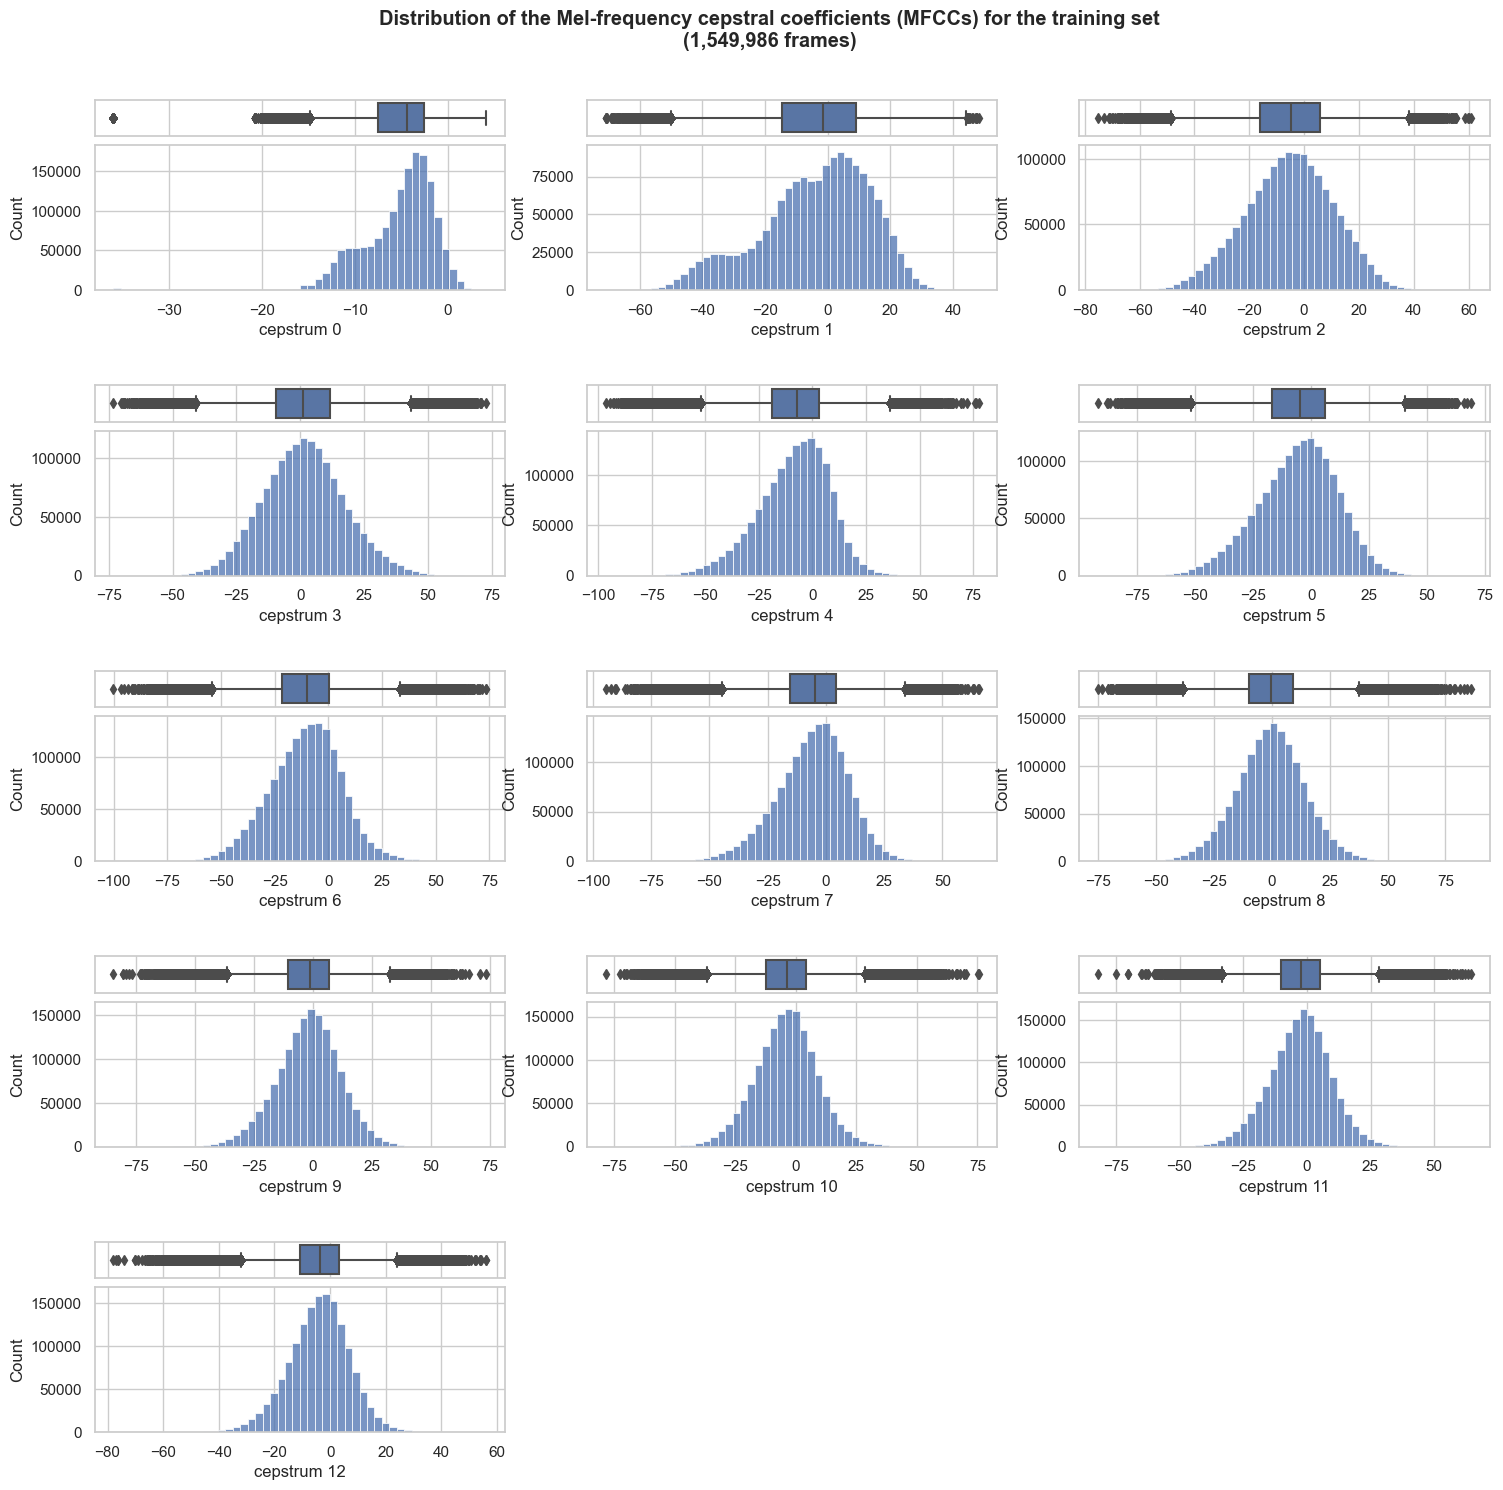

In [14]:
attr_list = ["cepstrum "+str(i) for i in range(0,13)]
show_hist_box(X_train, attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set", img_path="img/", do_save_to_disk=False)

In [15]:
## Compare male and female data (before removing outliers)

# male_train_idx = np.where(y_train == 0)
# female_train_idx = np.where(y_train == 1)

# fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15,20), sharex=False, sharey=False)
# for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
#     sns.boxplot(data=[X_train[np.ix_(male_train_idx[0], [i])].T, X_train[np.ix_(female_train_idx[0], [i])].T], orient="h", ax=ax)
#     ax.set(title=f'Distribution of {col}')
# plt.suptitle(f'Comparison of male and female MFCCs distributions for train set\n(Male=0, Female=1)')
# plt.tight_layout(pad=2)
# plt.show()

## Remove outliers
Removing Outliers using Interquartile Range 

In [16]:
# Compute the interquartile range of the data along the specified axis
from scipy.stats import iqr
iqr(X_train, axis=0)

array([ 4.89974744, 23.55972848, 21.72833182, 21.08172814, 22.03294725,
       23.03463898, 21.94637569, 19.69149431, 19.00037376, 17.32674821,
       16.3159035 , 15.40526481, 13.99175991])

In [17]:
# Computer lower and upper bounds
Q1, Q3 = np.percentile(X_train, [25,75], axis=0)
IQR = Q3 - Q1
lower_bounds = Q1 - 1.5 * IQR
upper_bounds = Q3 + 1.5 * IQR

with np.printoptions(precision=2):
    print(f"• Q1: {Q1}")
    print(f"• Q3: {Q3}")
    print(f"• IQR:{IQR}")
    print()
    print(f"• lower_bounds (Q1 - 1.5 * IQR): \n{lower_bounds}")
    print(f"• upper_bounds (Q3 + 1.5 * IQR): \n{upper_bounds}")

• Q1: [ -7.49 -14.59 -16.05  -9.38 -19.07 -17.07 -21.44 -15.18  -9.96 -10.5
 -12.16 -10.26 -10.94]
• Q3: [-2.59  8.97  5.68 11.7   2.96  5.96  0.51  4.51  9.04  6.82  4.15  5.15
  3.06]
• IQR:[ 4.9  23.56 21.73 21.08 22.03 23.03 21.95 19.69 19.   17.33 16.32 15.41
 13.99]

• lower_bounds (Q1 - 1.5 * IQR): 
[-14.84 -49.93 -48.64 -41.   -52.12 -51.63 -54.35 -44.72 -38.46 -36.49
 -36.64 -33.36 -31.92]
• upper_bounds (Q3 + 1.5 * IQR): 
[ 4.76 44.31 38.27 43.33 36.01 40.51 33.43 34.05 37.54 32.81 28.63 28.26
 24.04]


In [18]:
# find indexes of all rows above lower bounds
rows_above_lower_bounds_idx = np.all(np.greater(X_train, lower_bounds), axis=1)

# find indexes of all rows below upper bounds
rows_below_upper_bounds_idx = np.all(np.less(X_train, upper_bounds), axis=1)

# find indexes of all rows inside bounds
rows_inside_bounds = np.logical_and(rows_above_lower_bounds_idx, rows_below_upper_bounds_idx)

# keep only rows that have values above lower bounds
X_train_no_outliers = X_train[rows_inside_bounds, :]
y_train_no_outliers = y_train[rows_inside_bounds, :]

count_removed = len(X_train) - len(X_train_no_outliers)
print(f"Removed {count_removed:,} outliers ({count_removed/len(X_train):.1%})")

Removed 211,551 outliers (13.6%)


### Male + Female (without outliers)

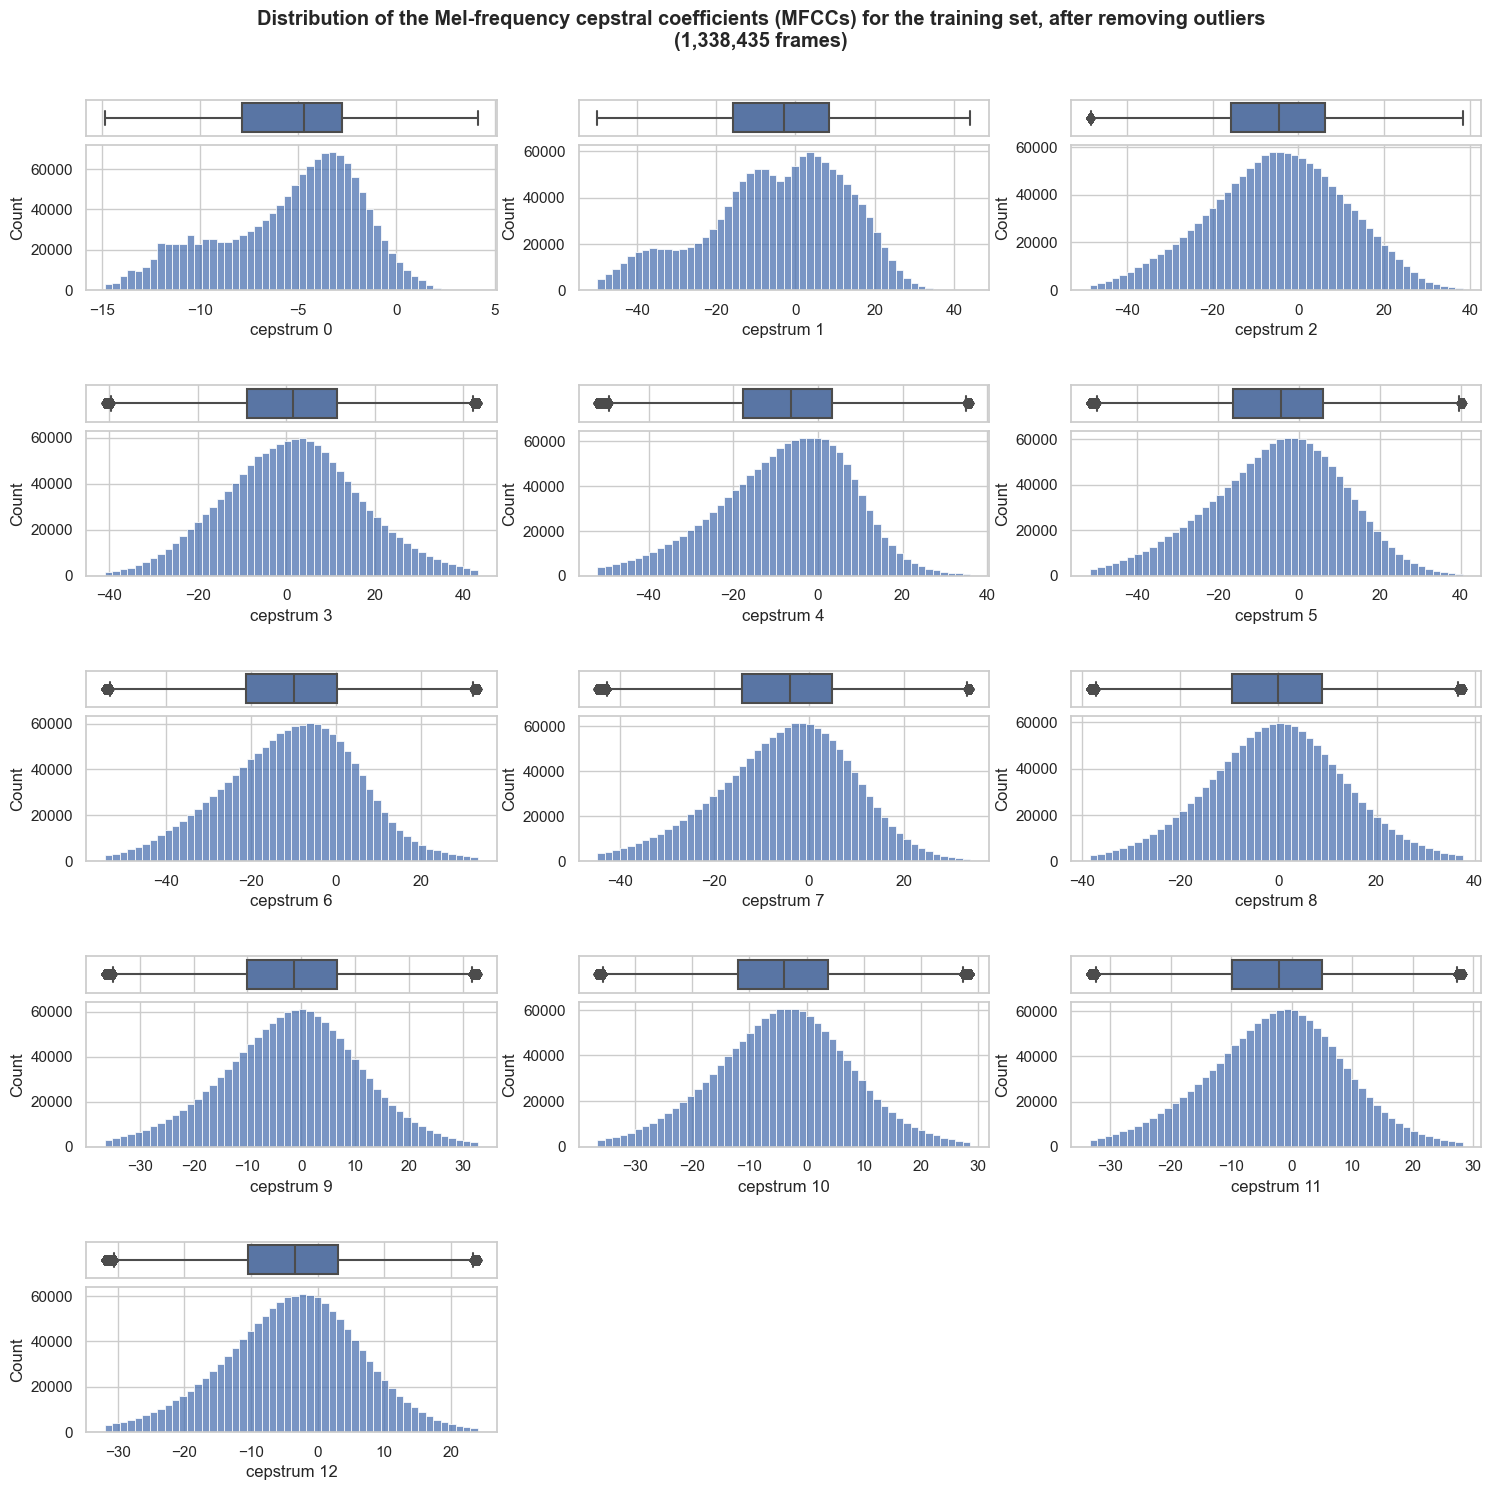

In [19]:
show_hist_box(X_train_no_outliers, attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set, after removing outliers", img_path="img/", do_save_to_disk=False)

In [20]:
male_train_no_outliers_idx = np.where(y_train_no_outliers == 0)
female_train_no_outliers_idx = np.where(y_train_no_outliers == 1)

### Male only (without outliers)

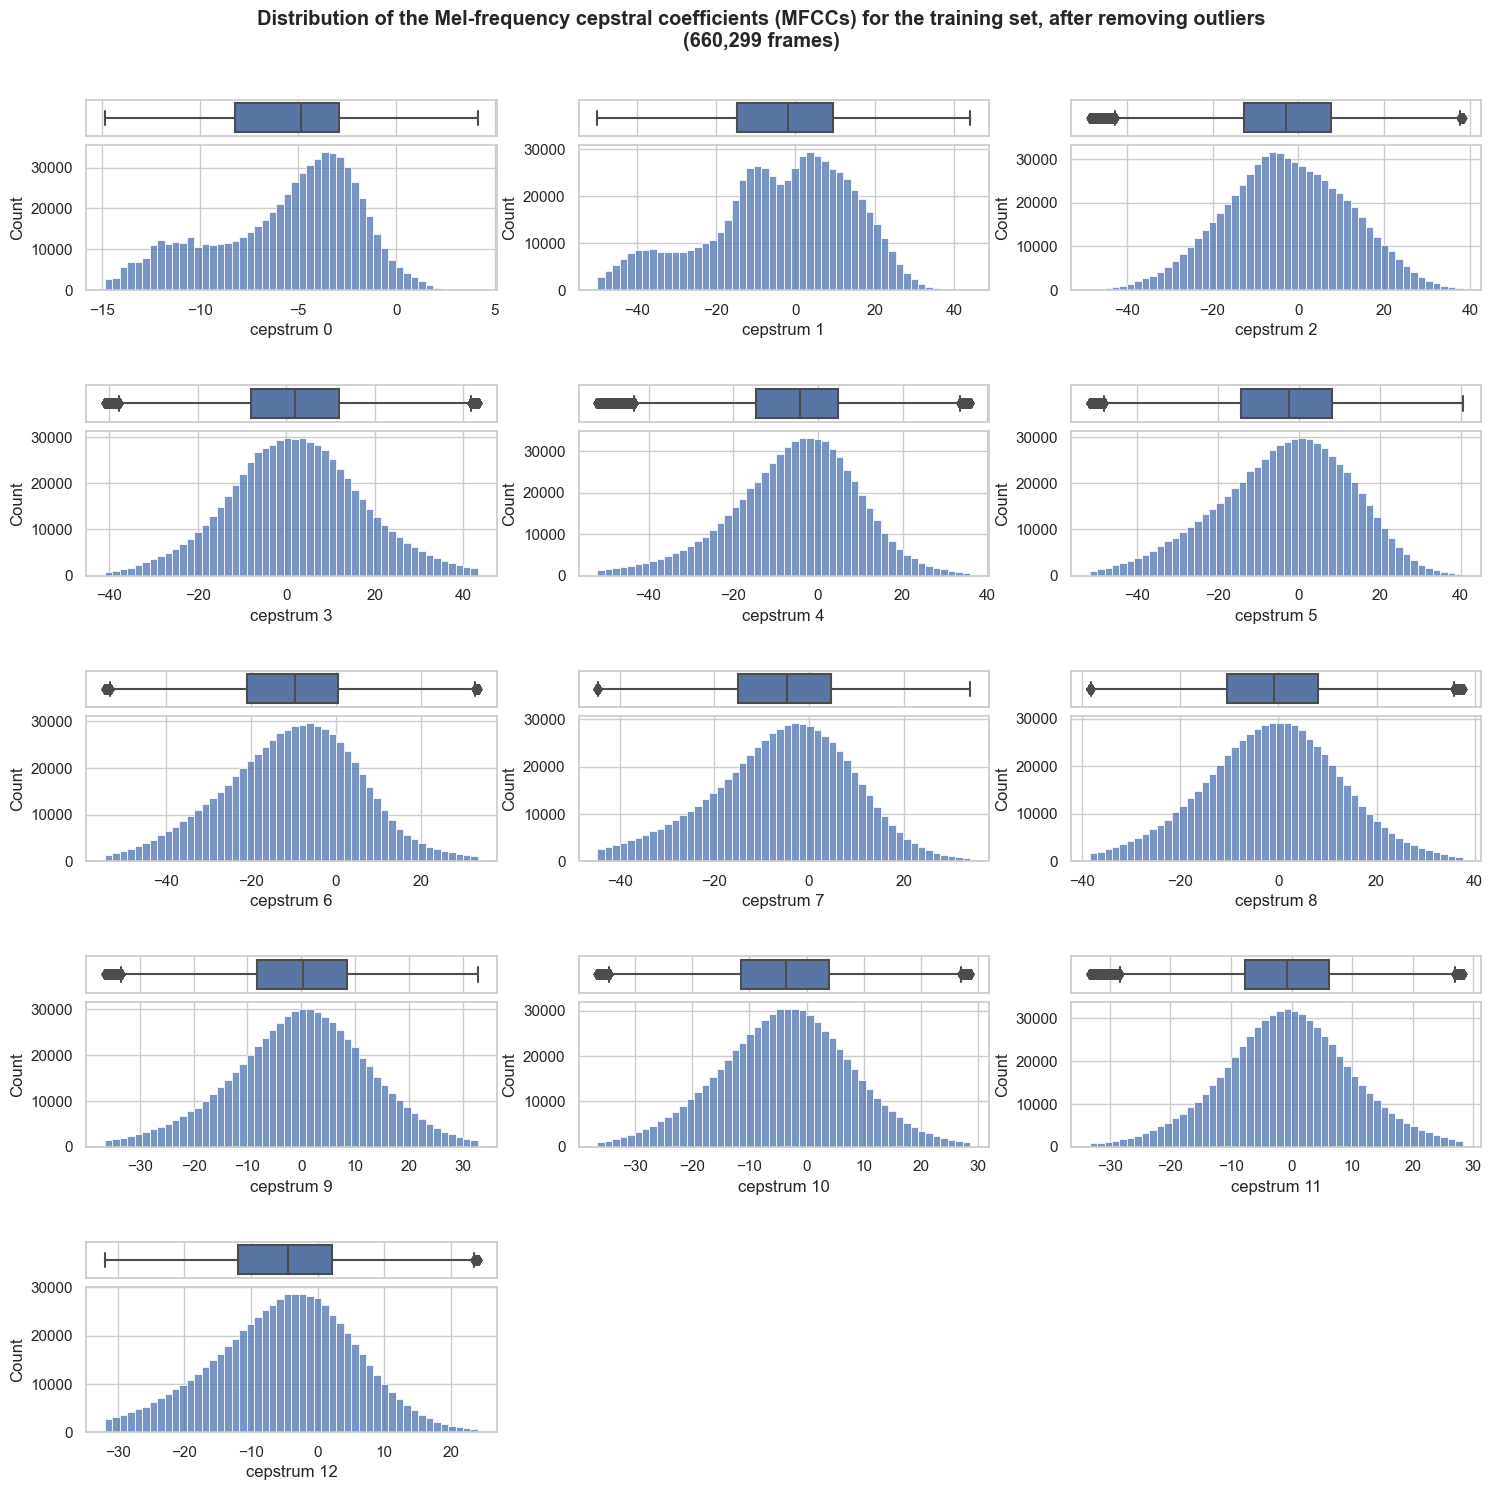

In [21]:
show_hist_box(X_train_no_outliers[male_train_no_outliers_idx[0], :], attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set, after removing outliers", img_path="img/", do_save_to_disk=False)

### Female only (without outliers)

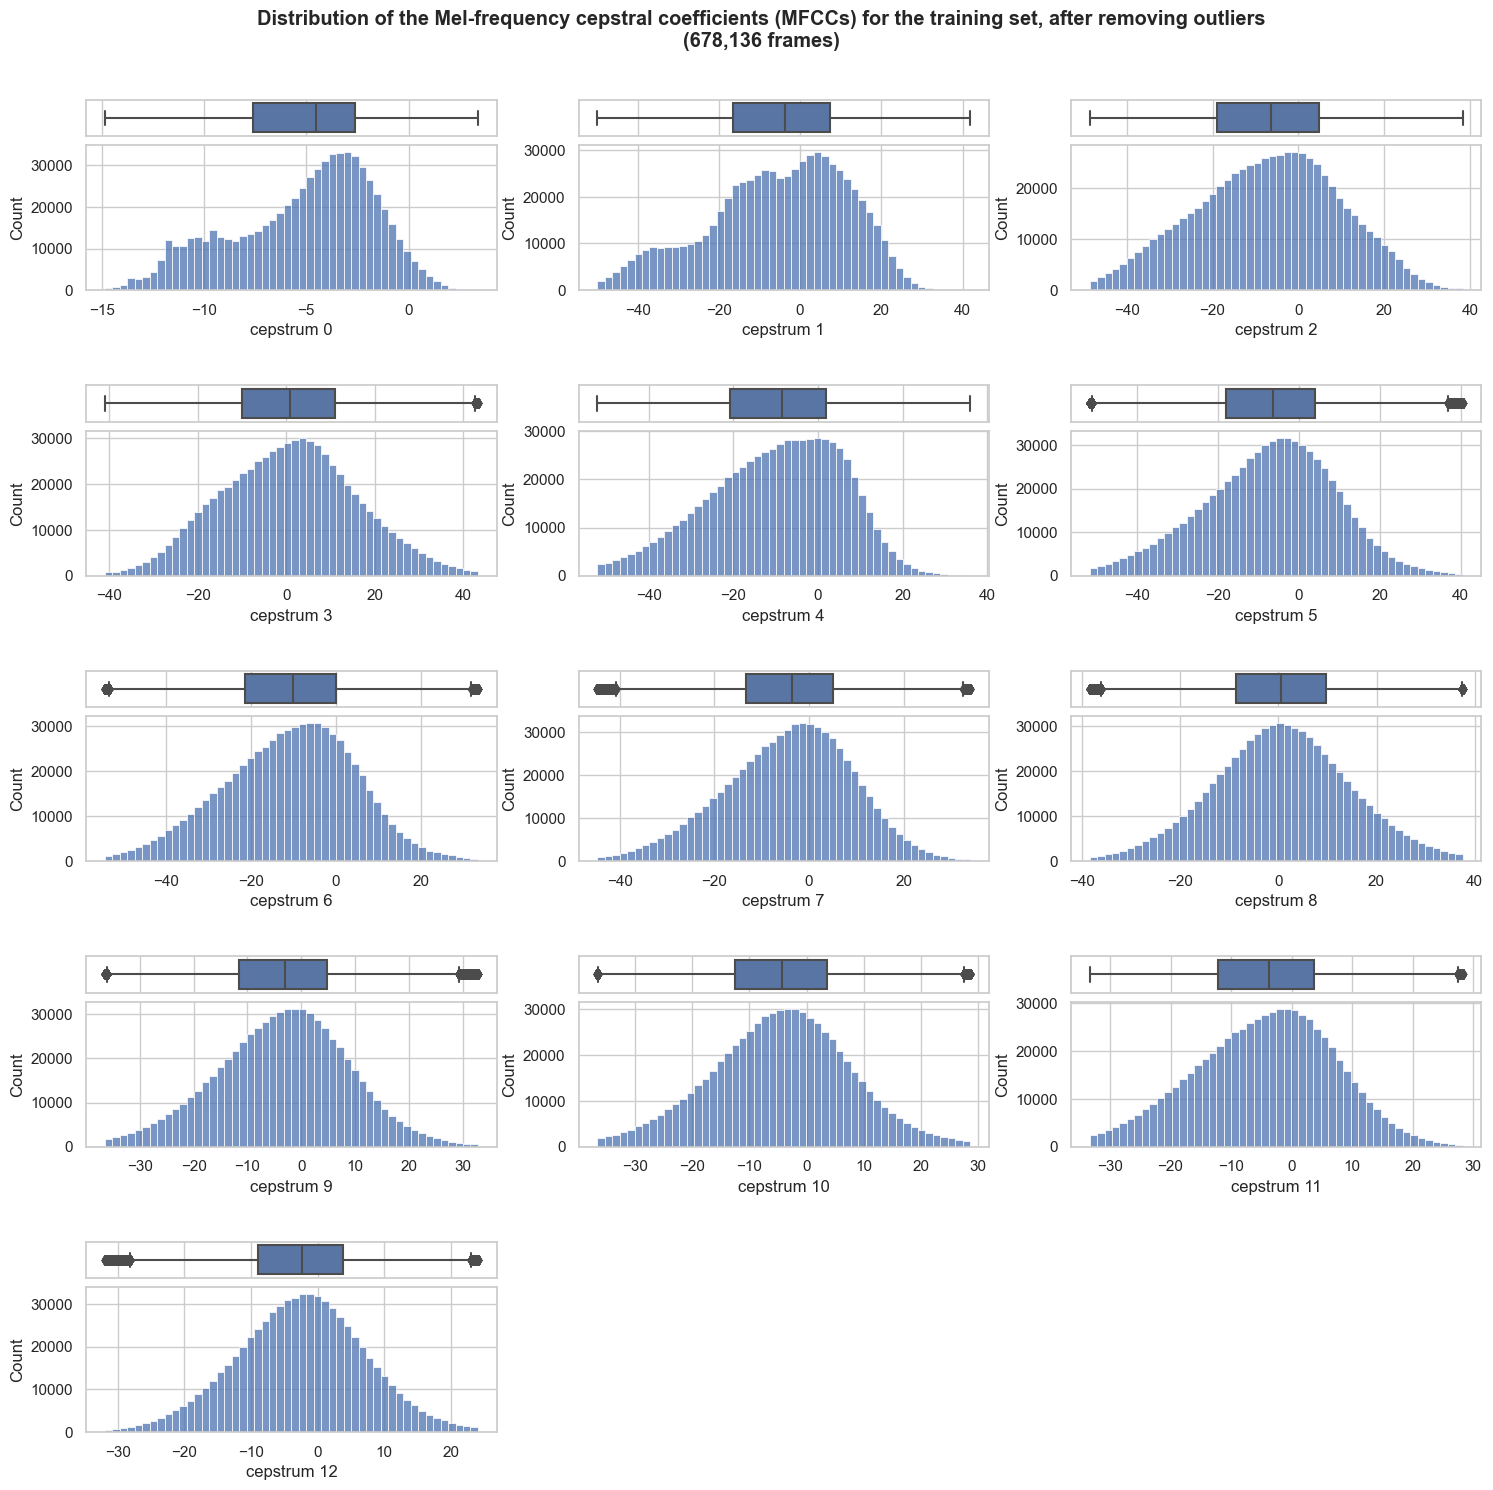

In [22]:
show_hist_box(X_train_no_outliers[female_train_no_outliers_idx[0], :], attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set, after removing outliers", img_path="img/", do_save_to_disk=False)

### Male and Female comparison

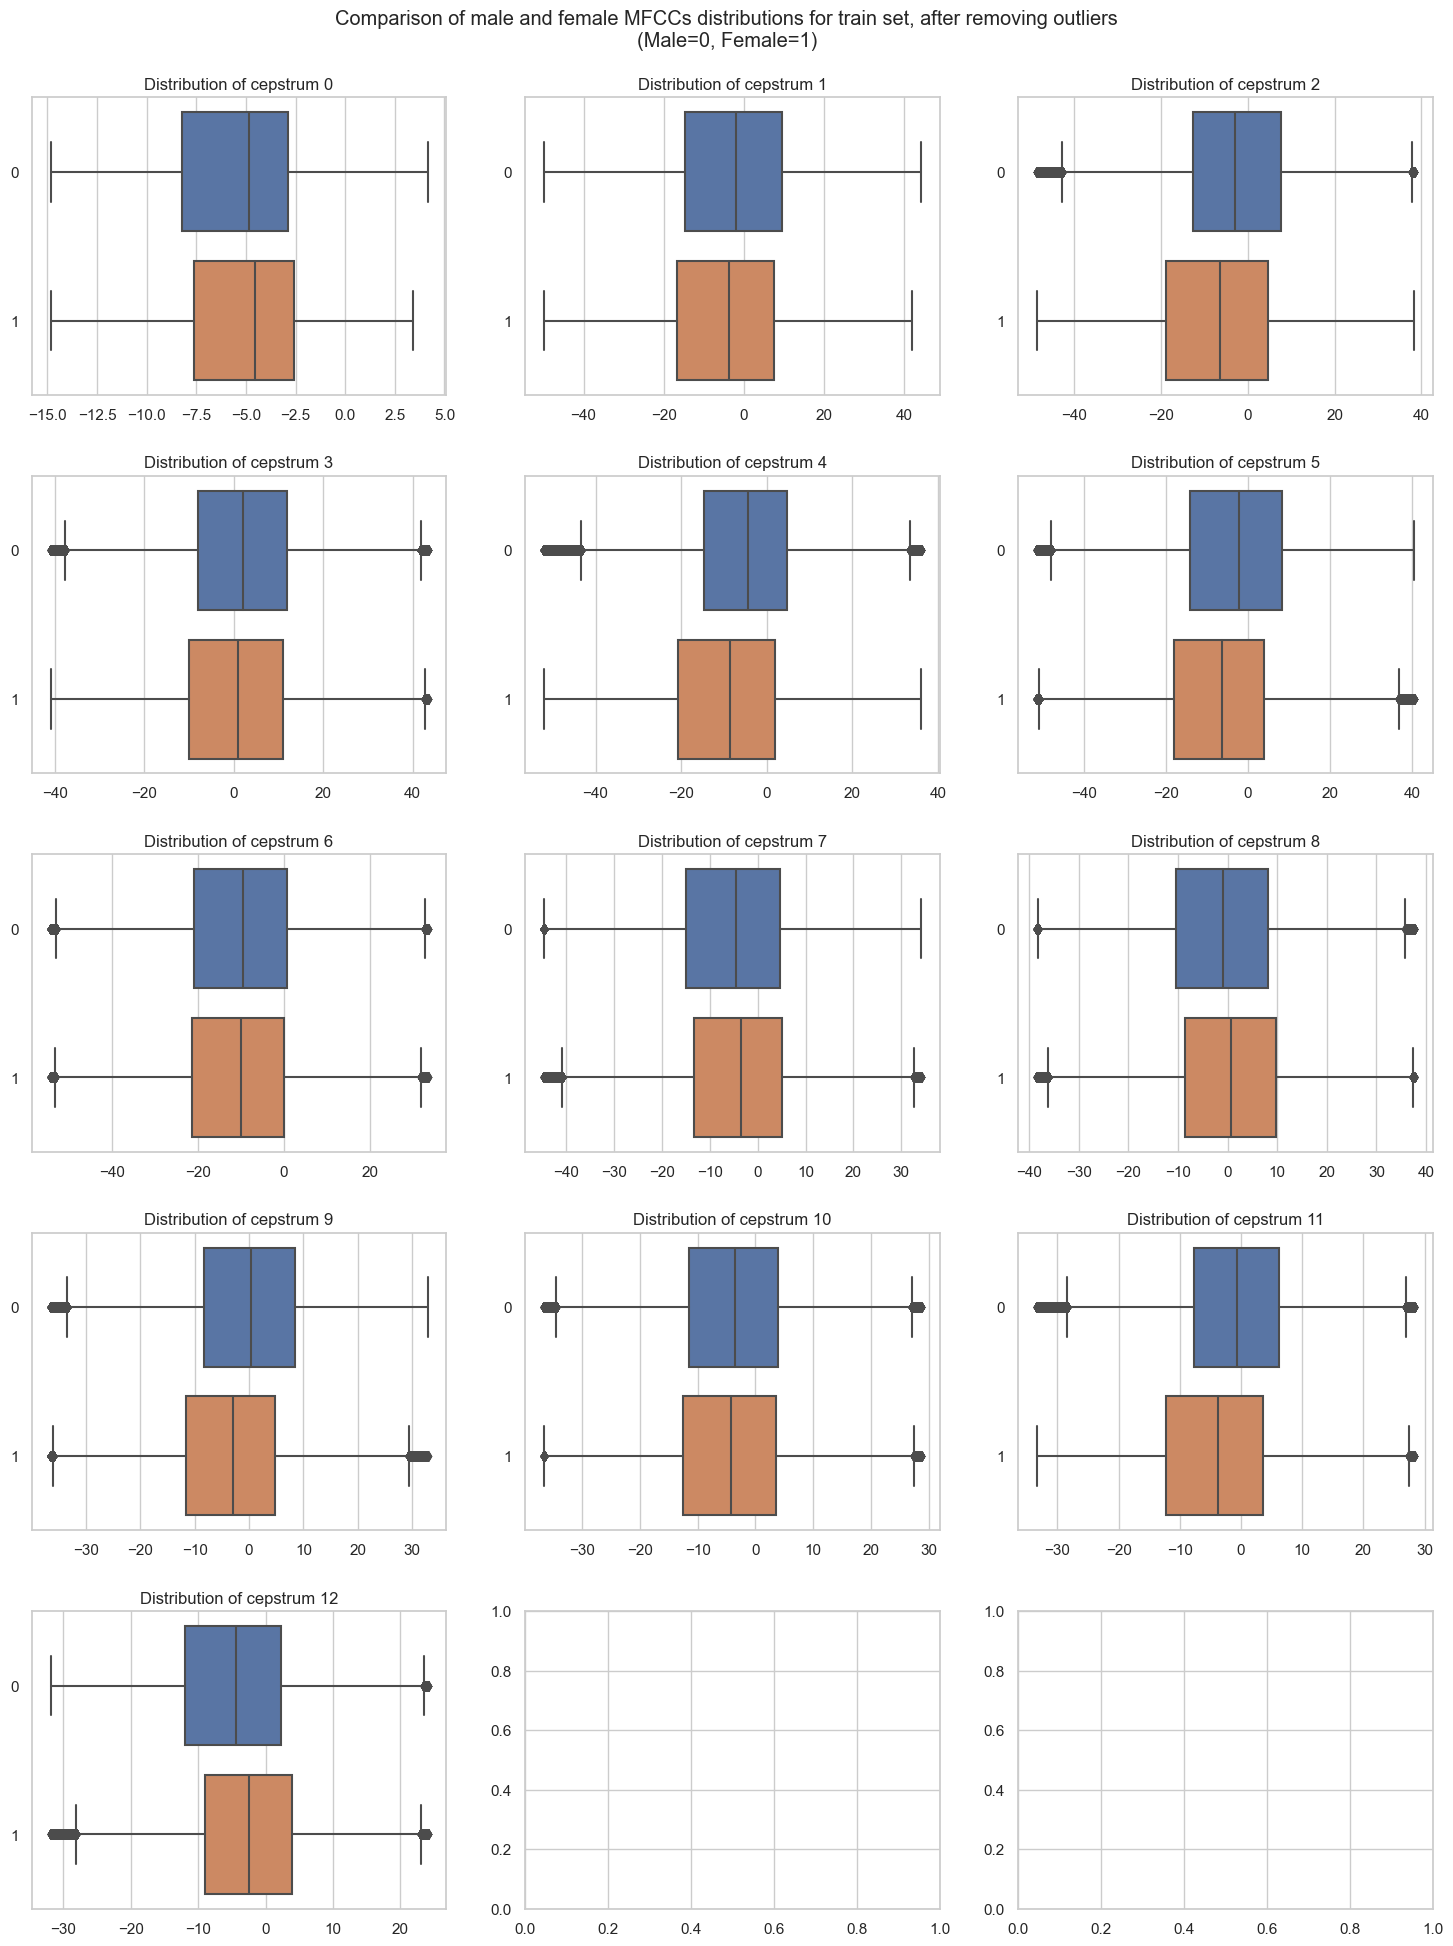

In [23]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15,20), sharex=False, sharey=False)
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    sns.boxplot(data=[X_train_no_outliers[np.ix_(male_train_no_outliers_idx[0], [i])].T, X_train_no_outliers[np.ix_(female_train_no_outliers_idx[0], [i])].T], orient="h", ax=ax)
    ax.set(title=f'Distribution of {col}')
plt.suptitle(f'Comparison of male and female MFCCs distributions for train set, after removing outliers\n(Male=0, Female=1)')
plt.tight_layout(pad=2)
plt.show()

**Observations:**

According to [Emmanuel Deruty](https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040), if a cepstral coefficient has a positive value, the majority of the spectral energy is concentrated in the low-frequency regions. On the other hand, if a cepstral coefficient has a negative value, it represents that most of the spectral energy is concentrated at high frequencies. 

We notice that for most cepstrum coefficients (1, 2, 3, 4, 5, 6, 9, 10, 11), the distributions of the male values are higher than the female ones, which matches the intuition that the male voice generally has a lower frequency than a female's voice.

## Normalize data

In [24]:
X_train.shape

(1549986, 13)

In [25]:
print("Before normalization: ")
with np.printoptions(precision=2):
    print(f"\n• X_train_no_outliers means: {np.mean(X_train_no_outliers, axis=0)}")
    print(f"\n• X_train_no_outliers std:   {np.std(X_train_no_outliers, axis=0)}")
    print(f"\n• X_test means:  {np.mean(X_test, axis=0)}")
    print(f"\n• X_test std:    {np.std(X_test, axis=0)}")
    
# Center to the mean and component wise scale to unit variance.
X_train_norm = preprocessing.scale(X_train_no_outliers, axis=0)
X_test_norm = preprocessing.scale(X_test, axis=0)

print("\n\nAfter normalization: ")
with np.printoptions(precision=2):
    print(f"\n• X_train_norm means: {np.mean(X_train_norm, axis=0)}")
    print(f"\n• X_train_norm std:   {np.std(X_train_norm, axis=0)}")
    print(f"\n• X_test_norm means:  {np.mean(X_test_norm, axis=0)}")
    print(f"\n• X_test_norm std:    {np.std(X_test_norm, axis=0)}")

Before normalization: 

• X_train_no_outliers means: [ -5.43  -4.86  -4.97   1.4   -7.77  -5.49 -10.67  -5.05  -0.32  -1.83
  -4.2   -2.6   -3.8 ]

• X_train_no_outliers std:   [ 3.57 17.48 15.78 15.18 15.47 16.41 15.64 14.08 13.81 12.53 11.78 11.15
 10.08]

• X_test means:  [ -5.42  -4.26  -8.01   3.34 -11.87 -12.09  -6.8   -6.27   0.35  -0.71
  -3.32  -3.57  -3.81]

• X_test std:    [ 3.74 17.74 16.29 16.98 16.45 17.78 15.98 15.55 14.95 13.15 13.29 11.39
 11.56]


After normalization: 

• X_train_norm means: [ 7.90e-16 -5.13e-15 -1.20e-14 -4.60e-16  1.83e-14 -6.65e-15 -3.11e-14
  1.54e-14 -1.08e-15  9.41e-16 -1.12e-14 -2.00e-15  1.10e-14]

• X_train_norm std:   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

• X_test_norm means:  [ 1.41e-14  2.06e-15  1.05e-14 -7.10e-15 -6.75e-16  5.42e-15 -1.26e-14
 -2.22e-15  3.18e-16 -6.79e-16 -8.39e-16  5.33e-15 -4.65e-15]

• X_test_norm std:    [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
